In [528]:
import logging
import os
import pickle
import time
import statistics
from abc import abstractmethod

import colorsys
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import hdbscan

from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
import statistics


<font size = 5>Load Data, Create airspeedchange feature and Drop other rows</font>

In [529]:
f0 = 'base.csv'
f1 = 'random1.csv'
f2 = 'wind1.csv'
f3 = 'engine1.csv'
f4 = 'sensor1.csv'
f5 = 'crash.csv'

base_df = pd.read_csv(f0, header=0, index_col=None)
random1_df = pd.read_csv(f1, header=0, index_col=None)
wind1_df = pd.read_csv(f2, header=0, index_col=None)
engine1_df = pd.read_csv(f3, header=0, index_col=None)
sensor1_df = pd.read_csv(f4, header=0, index_col=None)
crash1_df = pd.read_csv(f5, header=0, index_col=None)

df_list = [base_df, random1_df, wind1_df, engine1_df, sensor1_df,crash1_df]

for df in df_list:

    df['airspeedchange'] = df['airspeed']- df['airspeed'].shift(1)
    df['airspeedchange'].fillna(0, inplace=True)

base_df = base_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed',  'airspeedchange']]
random1_df = random1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]
wind1_df = wind1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]
engine1_df = engine1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]
sensor1_df = sensor1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]
crash1_df = crash1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]



<font size = 5>Count anomalies</font>

In [530]:
random1_nonanomalies = len(random1_df)
wind1_anomalies = len(wind1_df)
engine1_anomalies = len(engine1_df)
sensor1_anomalies = len(sensor1_df)
crash1_anomalies = len(crash1_df)


<font size = 5>Train K-Means Model with Base Dataset</font>

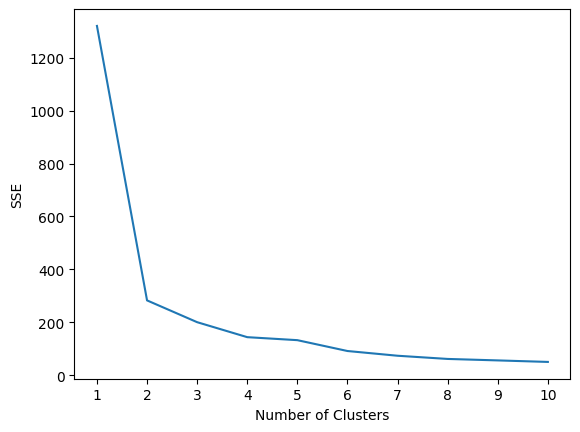

In [531]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(base_df)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [532]:
#actual k-means implementation

kmeans = KMeans(init="random", n_clusters=2, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(base_df)

#view cluster assignments for each observation
kmeans.labels_

#append cluster assingments to new DataFrame as we want to retain the original df
base_df2 = base_df.copy()
base_df2['cluster'] = kmeans.labels_

#view updated DataFrame
#initialize kmeans parameters
#base_df

#export to csv to view clusters for sense-making

base_df2.to_csv('kmeanstraining.csv')

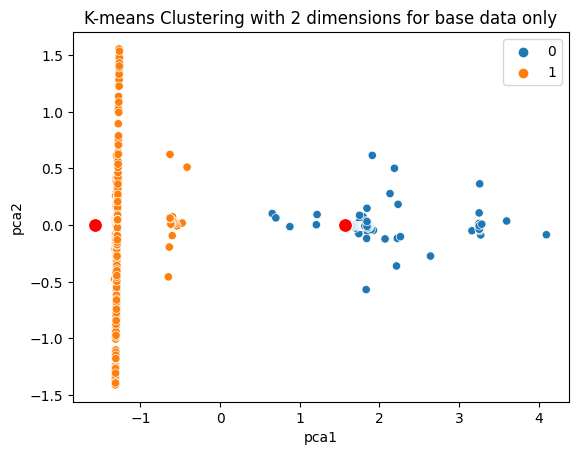

In [533]:
#plot to visualise clusters

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Run PCA on the data and reduce the dimensions in pca_num_components dimensions

pca_num_components = 2

cluster_centroids_reduced = PCA(n_components=pca_num_components).fit_transform(kmeans.cluster_centers_)
reduced_data = PCA(n_components=pca_num_components).fit_transform(base_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
cc_results = pd.DataFrame(cluster_centroids_reduced,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=base_df2['cluster'], data=results)
sns.scatterplot(x="pca1", y="pca2", c='red', s=100, data=cc_results)


plt.title('K-means Clustering with 2 dimensions for base data only')
plt.show()




In [534]:
#get cluster counts
kmeans_clusterCount = np.bincount(kmeans.labels_)
kmeans_clusterCount



array([171, 279])

<font size = 5>Predicting using random missions (RQ1)</font>

In [535]:
kmeans.predict(random1_df)

#append cluster assignments to new dataframe as we want to retain the original df
random1_df2 = random1_df.copy()
random1_df2['cluster'] = kmeans.predict(random1_df)

In [536]:
#prediction cluster counts
kmeans_prediction_clusterCount = np.bincount(random1_df2['cluster'])
kmeans_prediction_clusterCount

array([168, 186])

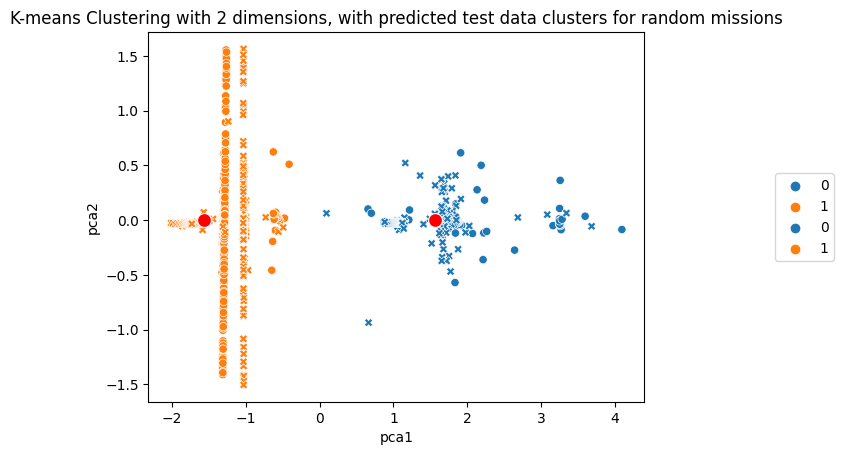

In [537]:
#plot against original plot
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(base_df2)
test_reduced_data = PCA(n_components=pca_num_components).fit_transform(random1_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
test_results = pd.DataFrame(test_reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=base_df2['cluster'], marker = 'o', data=results)
sns.scatterplot(x="pca1", y="pca2", hue = random1_df2['cluster'], marker = "X", data=test_results)
sns.scatterplot(x="pca1", y="pca2", c='red', s=100, data=cc_results)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('K-means Clustering with 2 dimensions, with predicted test data clusters for random missions')
plt.show()

<font size = 5> Finding number of nonanomalies for random missions </font>

In [538]:
centroids = kmeans.cluster_centers_

original_distances = []
for i in range(len(base_df)):
    centroid = centroids[int(base_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((base_df.iloc[i] - centroid)**2))
    original_distances.append(distance)

original_mean = sum(original_distances)/len(original_distances)
print("The original mean Euclidean distance is", original_mean)

original_std = np.std(original_distances)

threshold = original_mean + 3* original_std

predicted_distances = []
count = 0
for i in range(len(random1_df)):
    centroid = centroids[int(random1_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((random1_df.iloc[i] - centroid)**2))
    if distance > threshold:
        count+= 1
    predicted_distances.append(distance)

new_mean = sum(predicted_distances)/len(predicted_distances)
print("The new mean Euclidean distance is", new_mean)

print("The number of observations which had distances above the threshold is", count)

nonanomalies = random1_nonanomalies - count
nonanomaly_percent_random = nonanomalies/random1_nonanomalies*100

print("Out of the", random1_nonanomalies, "observations,", nonanomalies, "were identified as non-anomalies, giving us a percentage of", nonanomaly_percent_random, "%")


The original mean Euclidean distance is 0.6272943013374066
The new mean Euclidean distance is 0.7365020721725279
The number of observations which had distances above the threshold is 4
Out of the 354 observations, 350 were identified as non-anomalies, giving us a percentage of 98.87005649717514 %


In [539]:
base_silhouette_scores = silhouette_samples(base_df, kmeans.labels_)
random_silhouette_scores = silhouette_samples(random1_df, kmeans.predict(random1_df))

mean = np.mean(base_silhouette_scores)
standarddev = np.std(base_silhouette_scores)

bot_threshold = mean - (3 * standarddev)
top_threshold = mean + (3 * standarddev)

count = 0

for score in random_silhouette_scores:
    if score < bot_threshold or score > top_threshold:
        count += 1

print(count)


6


<font size = 5> Predicting using Wind Proxy (RQ2 1/4) </font>

In [540]:
kmeans.predict(wind1_df)

#append cluster assignments to new dataframe as we want to retain the original df
wind1_df2 = wind1_df.copy()
wind1_df2['cluster'] = kmeans.predict(wind1_df)

In [541]:
#prediction cluster counts
kmeans_prediction_clusterCount = np.bincount(wind1_df2['cluster'])
kmeans_prediction_clusterCount

array([649,  25])

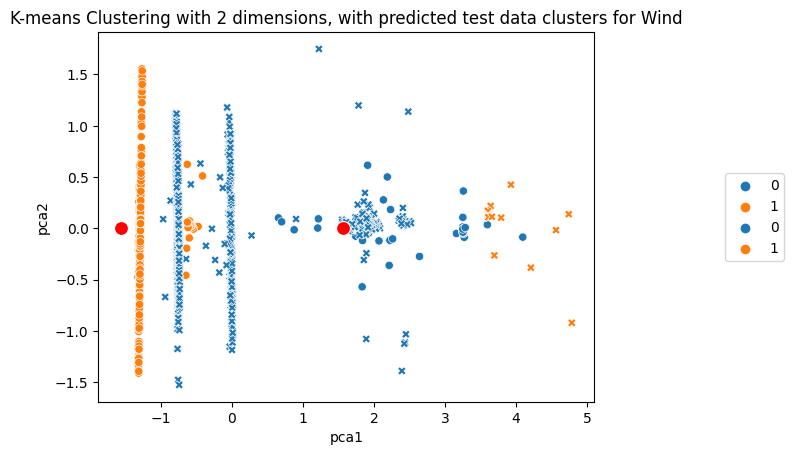

In [542]:
#plot against original plot
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(base_df2)
test_reduced_data = PCA(n_components=pca_num_components).fit_transform(wind1_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
test_results = pd.DataFrame(test_reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=base_df2['cluster'], marker = 'o', data=results)
sns.scatterplot(x="pca1", y="pca2", hue = wind1_df2['cluster'], marker = "X", data=test_results)
sns.scatterplot(x="pca1", y="pca2", c='red', s=100, data=cc_results)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('K-means Clustering with 2 dimensions, with predicted test data clusters for Wind')
plt.show()

<font size = 5> Finding number of outliers for Wind proxy </font>

In [543]:
centroids = kmeans.cluster_centers_

original_distances = []
for i in range(len(base_df)):
    centroid = centroids[int(base_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((base_df.iloc[i] - centroid)**2))
    original_distances.append(distance)

original_mean = sum(original_distances)/len(original_distances)
print("The original mean Euclidean distance is", original_mean)

original_std = np.std(original_distances)

threshold = original_mean + 3* original_std

predicted_distances = []
count = 0
for i in range(len(wind1_df)):
    centroid = centroids[int(wind1_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((wind1_df.iloc[i] - centroid)**2))
    if distance > threshold:
        count+= 1
    predicted_distances.append(distance)

new_mean = sum(predicted_distances)/len(predicted_distances)
print("The new mean Euclidean distance is", new_mean)

print("The number of observations which had distances above the threshold is", count)

anomaly_percent_wind = count/wind1_anomalies*100

print("Out of the", wind1_anomalies, "observations,", count, "were identified as anomalies, giving us a percentage of", anomaly_percent_wind, "%")


The original mean Euclidean distance is 0.6272943013374066
The new mean Euclidean distance is 2.0239332726935046
The number of observations which had distances above the threshold is 373
Out of the 674 observations, 373 were identified as anomalies, giving us a percentage of 55.34124629080118 %


In [544]:
base_silhouette_scores = silhouette_samples(base_df, kmeans.labels_)
wind_silhouette_scores = silhouette_samples(wind1_df, kmeans.predict(wind1_df))

mean = np.mean(base_silhouette_scores)
standarddev = np.std(base_silhouette_scores)

bot_threshold = mean - (3 * standarddev)
top_threshold = mean + (3 * standarddev)

count = 0

for score in wind_silhouette_scores:
    if score < bot_threshold or score > top_threshold:
        count += 1

print(count)


95


<font size = 5> Predicting using Engine Faults (RQ2 2/4) </font>



In [545]:
kmeans.predict(engine1_df)

#append cluster assignments to new dataframe as we want to retain the original df
engine1_df2 = engine1_df.copy()
engine1_df2['cluster'] = kmeans.predict(engine1_df)

In [546]:
#prediction cluster counts
kmeans_prediction_clusterCount = np.bincount(engine1_df2['cluster'])
kmeans_prediction_clusterCount

array([421,  49])

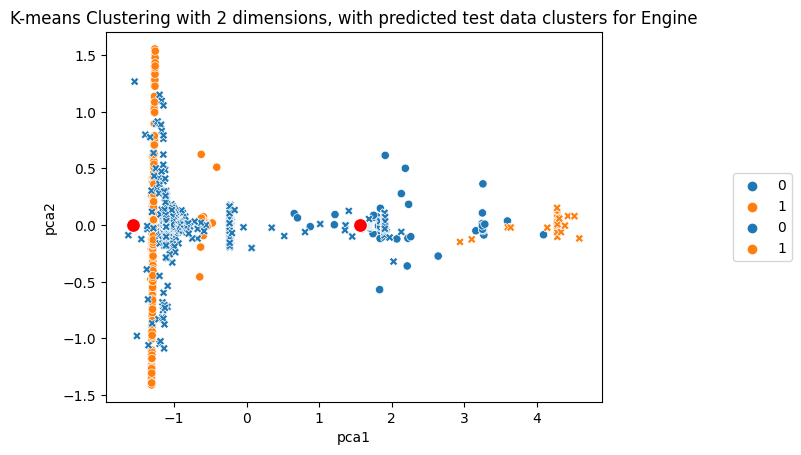

In [547]:
#plot against original plot
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(base_df2)
test_reduced_data = PCA(n_components=pca_num_components).fit_transform(engine1_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
test_results = pd.DataFrame(test_reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=base_df2['cluster'], marker = 'o', data=results)
sns.scatterplot(x="pca1", y="pca2", hue = engine1_df2['cluster'], marker = "X", data=test_results)
sns.scatterplot(x="pca1", y="pca2", c='red', s=100, data=cc_results)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('K-means Clustering with 2 dimensions, with predicted test data clusters for Engine')
plt.show()

<font size = 5> Finding number of outliers for Engine Faults </font>

In [548]:
centroids = kmeans.cluster_centers_

original_distances = []
for i in range(len(base_df)):
    centroid = centroids[int(base_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((base_df.iloc[i] - centroid)**2))
    original_distances.append(distance)

original_mean = sum(original_distances)/len(original_distances)
print("The original mean Euclidean distance is", original_mean)

original_std = np.std(original_distances)

threshold = original_mean + 3* original_std

predicted_distances = []
count = 0
for i in range(len(engine1_df)):
    centroid = centroids[int(engine1_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((engine1_df.iloc[i] - centroid)**2))
    if distance > threshold:
        count+= 1
    predicted_distances.append(distance)

new_mean = sum(predicted_distances)/len(predicted_distances)
print("The new mean Euclidean distance is", new_mean)

print("The number of observations which had distances above the threshold is", count)

anomaly_percent_engine = count/engine1_anomalies*100

print("Out of the", engine1_anomalies, "observations,", count, "were identified as anomalies, giving us a percentage of", anomaly_percent_engine, "%")


The original mean Euclidean distance is 0.6272943013374066
The new mean Euclidean distance is 1.742999032485785
The number of observations which had distances above the threshold is 281
Out of the 470 observations, 281 were identified as anomalies, giving us a percentage of 59.787234042553195 %


<font size = 5> Predicting using Manually Injected Sensor Faults (RQ2 3/4) </font>


In [549]:
kmeans.predict(sensor1_df)

#append cluster assignments to new dataframe as we want to retain the original df
sensor1_df2 = sensor1_df.copy()
sensor1_df2['cluster'] = kmeans.predict(sensor1_df)

In [550]:
#prediction cluster counts
kmeans_prediction_clusterCount = np.bincount(sensor1_df2['cluster'])
kmeans_prediction_clusterCount

array([209,   3])

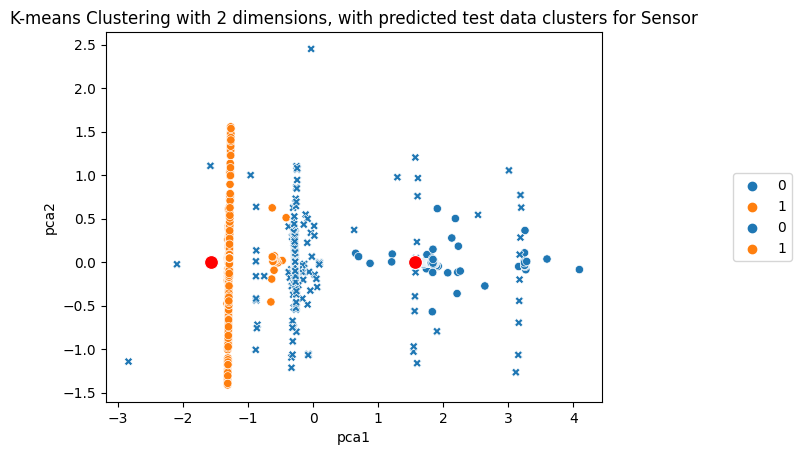

In [551]:
#plot against original plot
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(base_df2)
test_reduced_data = PCA(n_components=pca_num_components).fit_transform(sensor1_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
test_results = pd.DataFrame(test_reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=base_df2['cluster'], marker = 'o', data=results)
sns.scatterplot(x="pca1", y="pca2", hue = wind1_df2['cluster'], marker = "X", data=test_results)
sns.scatterplot(x="pca1", y="pca2", c='red', s=100, data=cc_results)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('K-means Clustering with 2 dimensions, with predicted test data clusters for Sensor')
plt.show()

<font size = 5> Finding number of outliers for Sensor Faults </font>

In [552]:
centroids = kmeans.cluster_centers_

original_distances = []
for i in range(len(base_df)):
    centroid = centroids[int(base_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((base_df.iloc[i] - centroid)**2))
    original_distances.append(distance)

original_mean = sum(original_distances)/len(original_distances)
print("The original mean Euclidean distance is", original_mean)

original_std = np.std(original_distances)

threshold = original_mean + 3* original_std

predicted_distances = []
count = 0
for i in range(len(sensor1_df)):
    centroid = centroids[int(sensor1_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((sensor1_df.iloc[i] - centroid)**2))
    if distance > threshold:
        count+= 1
    predicted_distances.append(distance)

new_mean = sum(predicted_distances)/len(predicted_distances)
print("The new mean Euclidean distance is", new_mean)

print("The number of observations which had distances above the threshold is", count)

anomaly_percent_sensor = count/sensor1_anomalies*100

print("Out of the", sensor1_anomalies, "observations,", count, "were identified as anomalies, giving us a percentage of", anomaly_percent_sensor, "%")


The original mean Euclidean distance is 0.6272943013374066
The new mean Euclidean distance is 3.3685368943242815
The number of observations which had distances above the threshold is 212
Out of the 212 observations, 212 were identified as anomalies, giving us a percentage of 100.0 %


<font size = 5> Predicting using Crash (RQ2 4/4) </font>

In [553]:
kmeans.predict(crash1_df)

#append cluster assignments to new dataframe as we want to retain the original df
crash1_df2 = crash1_df.copy()
crash1_df2['cluster'] = kmeans.predict(crash1_df)

In [554]:
#prediction cluster counts
kmeans_prediction_clusterCount = np.bincount(crash1_df2['cluster'])
kmeans_prediction_clusterCount

array([65,  9])

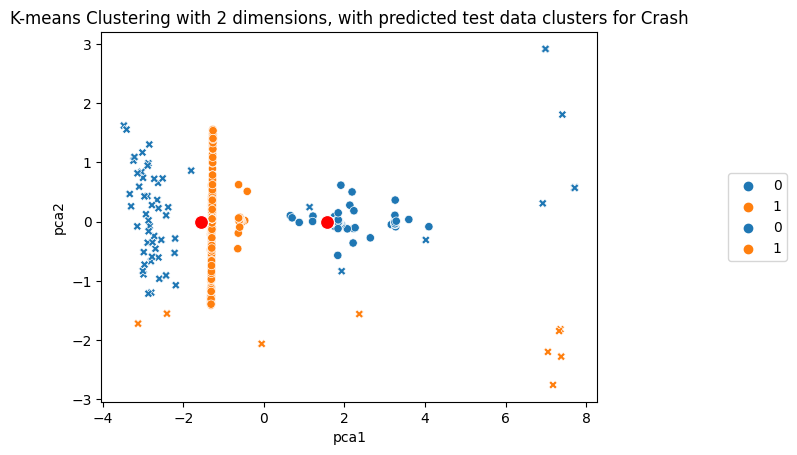

In [555]:
#plot against original plot
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(base_df2)
test_reduced_data = PCA(n_components=pca_num_components).fit_transform(crash1_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
test_results = pd.DataFrame(test_reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=base_df2['cluster'], marker = 'o', data=results)
sns.scatterplot(x="pca1", y="pca2", hue = crash1_df2['cluster'], marker = "X", data=test_results)
sns.scatterplot(x="pca1", y="pca2", c='red', s=100, data=cc_results)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('K-means Clustering with 2 dimensions, with predicted test data clusters for Crash')
plt.show()

In [556]:
centroids = kmeans.cluster_centers_

original_distances = []
for i in range(len(base_df)):
    centroid = centroids[int(base_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((base_df.iloc[i] - centroid)**2))
    original_distances.append(distance)

original_mean = sum(original_distances)/len(original_distances)
print("The original mean Euclidean distance is", original_mean)

original_std = np.std(original_distances)

threshold = original_mean + 3* original_std

predicted_distances = []
count = 0
for i in range(len(crash1_df)):
    centroid = centroids[int(crash1_df2.iloc[i]['cluster'])]
    distance = np.sqrt(np.sum((crash1_df.iloc[i] - centroid)**2))
    if distance > threshold:
        count+= 1
    predicted_distances.append(distance)

new_mean = sum(predicted_distances)/len(predicted_distances)
print("The new mean Euclidean distance is", new_mean)

print("The number of observations which had distances above the threshold is", count)

anomaly_percent_sensor = count/crash1_anomalies*100

print("Out of the", crash1_anomalies, "observations,", count, "were identified as anomalies, giving us a percentage of", anomaly_percent_sensor, "%")


The original mean Euclidean distance is 0.6272943013374066
The new mean Euclidean distance is 7.992665145130692
The number of observations which had distances above the threshold is 68
Out of the 74 observations, 68 were identified as anomalies, giving us a percentage of 91.8918918918919 %
